In [4]:
import pandas as pd
import numpy as np

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set(rc={'figure.figsize': (9, 6)})

In [7]:
events_data = pd.read_csv('event_data_train.zip', compression='zip')

In [8]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [9]:
events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')

In [10]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [11]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [12]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [13]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [14]:
events_data['day'] = events_data.date.dt.date

In [38]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


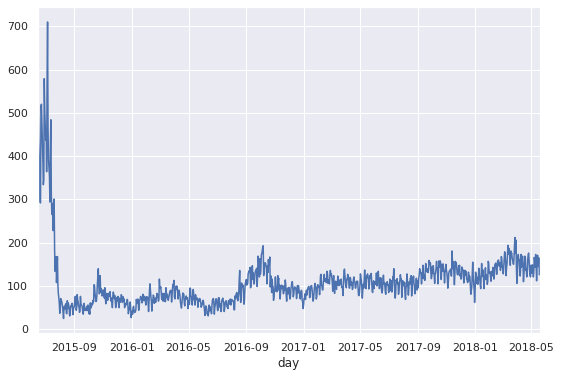

In [16]:
events_data.groupby('day').user_id.nunique().plot()

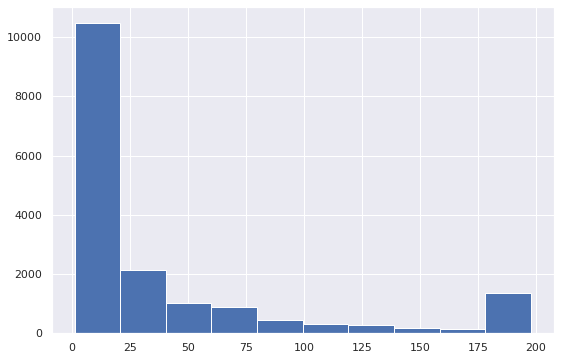

In [17]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

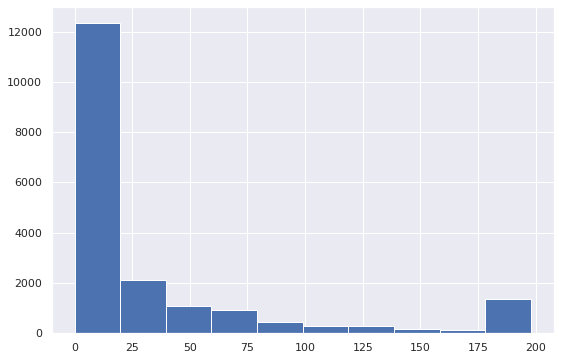

In [18]:
events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().passed.hist()

In [19]:
submission_data = pd.read_csv('submissions_data_train.zip', compression='zip')

In [20]:
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [21]:
submission_data['date'] = pd.to_datetime(submission_data['timestamp'], unit='s')

In [22]:
submission_data['day'] = submission_data.date.dt.date

In [23]:
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [24]:
users_scores = submission_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [25]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [26]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [27]:
gap_data = pd.Series(np.concatenate(gap_data, axis= 0))

In [28]:
gap_data = gap_data / (24 * 60 * 60)

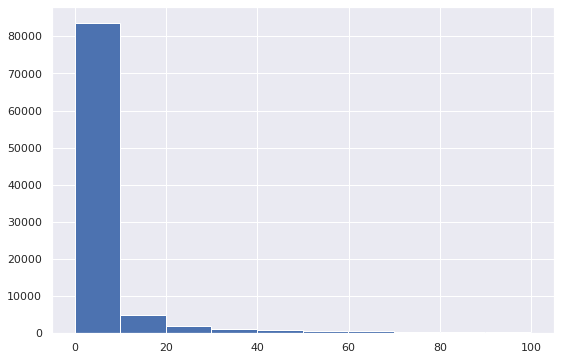

In [29]:
gap_data[gap_data < 100].hist()

In [30]:
gap_data.quantile(0.90)

18.325995370370403

In [31]:
events_data.groupby('user_id').agg({'timestamp': 'count'}).sort_values('timestamp', ascending=False).head()

,timestamp
user_id,
20907,33043
10794,16436
25279,10179
1046,9095
3572,7905


In [32]:
users_scores.sort_values('correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


In [37]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [41]:
now = 1526772811
drop_out_threshold = 30 * 24 * 60 * 60

In [42]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [43]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [46]:
users_data.merge(users_scores, on='user_id', how='outer').head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [47]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [48]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [49]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')

In [50]:
users_data.head()

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed
0,1,1472827464,True,1,0,0,1
1,2,1519226966,True,9,9,2,10
2,3,1444581588,True,91,87,30,192
3,5,1499859939,True,11,11,4,12
4,7,1521634660,True,1,1,0,1


In [51]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [55]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [56]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [57]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [59]:
users_data['passed_corse'] = users_data.passed > 170

In [60]:
users_data.head()

,user_id,last_timestamp,is_gone_user,discovered,passed,started_attempt,viewed,correct,wrong,day,passed_corse
0,1,1472827464,True,1,0,0,1,NaN,NaN,1,False
1,2,1519226966,True,9,9,2,10,2.0,0.0,2,False
2,3,1444581588,True,91,87,30,192,29.0,23.0,7,False
3,5,1499859939,True,11,11,4,12,2.0,2.0,2,False
4,7,1521634660,True,1,1,0,1,NaN,NaN,1,False
